In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from tabulate import tabulate
from itertools import product

# Modelos de Machine Learning
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Model Selection y Validación
from sklearn.model_selection import (
    train_test_split, cross_val_score, learning_curve, validation_curve
)

# Métricas
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, precision_score, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay
)


In [22]:
# Cargar el archivo CSV limpio
data_limpia = pd.read_csv('../data/data_limpia.csv')

# Ver las primeras filas del DataFrame para confirmar que se ha cargado correctamente
data_limpia.head()

,CODE,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,...,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad_Cliente,Tiempo
0,0,0,0,0,1,1,0,0,1,1,...,2,0,2,1,2892,0,0,2,18,0
1,11111,0,0,0,1,1,0,0,0,1,...,2,1,3,0,1376,7187,0,2,53,0
2,22222,0,0,0,1,1,3,0,1,1,...,1,0,3,0,1376,0,1,4,21,3
3,33333,0,0,0,1,1,2,0,0,1,...,1,1,2,1,2015,7256,1,4,48,5
4,53605,0,0,0,1,1,2,0,0,1,...,1,1,1,0,2015,11293,0,2,56,0


In [23]:
# Definir las características (features) y el objetivo (target)
X = data_limpia.drop(columns=['Mas_1_coche', 'Tiempo'])  # Eliminamos también la columna 'Tiempo'
y = data_limpia['Mas_1_coche']  # Objetivo (si el cliente comprará un segundo coche)

In [24]:
# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Definir los parámetros para la búsqueda de Grid (con parámetros ajustados)
param_grid = {
    'n_estimators': [200],  # Reducir los estimadores a 100 o 200
    'learning_rate': [0.05, 0.1],  # Reducir la tasa de aprendizaje
    'max_depth': [16, 18],  # Profundidad máxima de los árboles
}

# Almacenar los resultados
results = []

# Modelos a probar
models = {
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Iterar sobre cada modelo y cada combinación de hiperparámetros
for model_name, model in models.items():
    for params in product(*param_grid.values()):
        n_estimators, learning_rate, max_depth = params
        
        # Asegurarse de que max_depth sea un valor entero para XGBoost
        max_depth = int(max_depth)
        
        # Configurar el modelo con los parámetros actuales
        if model_name == 'AdaBoost':
            model.set_params(n_estimators=n_estimators, learning_rate=learning_rate)
        elif model_name == 'GradientBoosting':
            model.set_params(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
        elif model_name == 'XGBoost':
            model.set_params(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predecir en el conjunto de prueba
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
        y_pred = (y_pred_proba > 0.4).astype(int)  # Ajustar umbral de decisión
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')  # Enfocarse en recall
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Validación cruzada
        cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='recall')  # Optimizar recall
        mean_cv_score = np.mean(cv_scores)
        
        # Guardar los resultados
        results.append({
            'model': model_name,
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth if model_name != 'AdaBoost' else None,
            'accuracy': accuracy,
            'f1_score': f1,
            'recall': recall,
            'roc_auc': roc_auc,
            'cv_recall': mean_cv_score  # Guardar recall en validación cruzada
        })

# Convertir a DataFrame y ordenar por recall
results_df = pd.DataFrame(results).sort_values(by=['recall', 'f1_score'], ascending=False)

# Mostrar los mejores modelos optimizados para recall
display(results_df.head(5))

# Graficar las métricas: Curva ROC y Recall vs Umbral para el mejor modelo
best_model = results_df.iloc[0]
best_model_params = best_model.drop(['accuracy', 'f1_score', 'recall', 'roc_auc', 'cv_recall']).to_dict()

# Crear el mejor modelo con los parámetros óptimos
if best_model['model'] == 'AdaBoost':
    best_model_obj = AdaBoostClassifier(
        n_estimators=best_model_params['n_estimators'],
        learning_rate=best_model_params['learning_rate'],
        random_state=42
    )
elif best_model['model'] == 'GradientBoosting':
    best_model_obj = GradientBoostingClassifier(
        n_estimators=best_model_params['n_estimators'],
        learning_rate=best_model_params['learning_rate'],
        max_depth=best_model_params['max_depth'],
        random_state=42
    )
else:  # XGBoost
    best_model_obj = xgb.XGBClassifier(
        n_estimators=best_model_params['n_estimators'],
        learning_rate=best_model_params['learning_rate'],
        max_depth=int(best_model_params['max_depth']),  # Asegurarse de que max_depth sea int
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )

# Entrenar el mejor modelo
best_model_obj.fit(X_train, y_train)

# Calcular las probabilidades de la clase positiva
y_pred_proba = best_model_obj.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title(f'Curva ROC - {best_model["model"]}')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Graficar Recall vs Umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='Recall')
plt.title('Recall vs Umbral de Decisión')
plt.xlabel('Umbral de Decisión')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

# Matriz de Confusión
y_pred = best_model_obj.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clase 0', 'Clase 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Matriz de Confusión - {best_model["model"]}')
plt.show()


KeyboardInterrupt: 

In [ ]:
# Calcular el score en el conjunto de entrenamiento
train_score = best_model_obj.score(X_train, y_train)

# Determinar si hay sobreajuste basado en la validación cruzada
if train_score > 1.5 * best_model["cv_recall"]:
    overfitting_warning = "SEVERE OVERFITTING"
elif train_score > 1.2 * best_model["cv_recall"]:
    overfitting_warning = "DANGER"
elif train_score > 1.1 * best_model["cv_recall"]:
    overfitting_warning = "MILD OVERFITTING"
else:
    overfitting_warning = "OK"

print(f"Train Score: {train_score:.4f}")
print(f"Cross-validation Recall: {best_model['cv_recall']:.4f}")
print(f"Overfitting Status: {overfitting_warning}")


NameError: name 'train_score' is not defined

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Definir los parámetros para la búsqueda de Grid (con parámetros ajustados)
param_grid = {
    'n_estimators': [200],  # Reducir los estimadores a 100 o 200
    'learning_rate': [0.1],  # Reducir la tasa de aprendizaje
    'max_depth': [14],  # Profundidad máxima de los árboles
    'min_samples_split': [13],  # Parámetro adicional
    'min_samples_leaf': [3],  # Parámetro adicional
}

# Almacenar los resultados
results = []

# Modelos a probar
models = {
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)  # Sin use_label_encoder ni eval_metric
}

# Iterar sobre cada modelo y cada combinación de hiperparámetros
for model_name, model in models.items():
    for params in product(*param_grid.values()):
        n_estimators, learning_rate, max_depth, min_samples_split, min_samples_leaf = params
        
        # Asegurarse de que max_depth sea un valor entero para XGBoost
        max_depth = int(max_depth)
        
        # Configurar el modelo con los parámetros actuales
        if model_name == 'AdaBoost':
            model.set_params(n_estimators=n_estimators, learning_rate=learning_rate)
        elif model_name == 'GradientBoosting':
            model.set_params(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
                             min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        elif model_name == 'XGBoost':
            model.set_params(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
                             min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predecir en el conjunto de prueba
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
        y_pred = (y_pred_proba > 0.4).astype(int)  # Ajustar umbral de decisión
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')  # Enfocarse en recall
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Validación cruzada
        cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='recall')  # Optimizar recall
        mean_cv_score = np.mean(cv_scores)
        
        # Guardar los resultados
        results.append({
            'model': model_name,
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth if model_name != 'AdaBoost' else None,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'accuracy': accuracy,
            'f1_score': f1,
            'recall': recall,
            'roc_auc': roc_auc,
            'cv_recall': mean_cv_score  # Guardar recall en validación cruzada
        })

# Convertir a DataFrame y ordenar por recall
results_df = pd.DataFrame(results).sort_values(by=['recall', 'f1_score'], ascending=False)

# Mostrar los mejores modelos optimizados para recall
display(results_df.head(5))

# Graficar las métricas: Curva ROC y Recall vs Umbral para el mejor modelo
best_model = results_df.iloc[0]
best_model_params = best_model.drop(['accuracy', 'f1_score', 'recall', 'roc_auc', 'cv_recall']).to_dict()

# Crear el mejor modelo con los parámetros óptimos
if best_model['model'] == 'AdaBoost':
    best_model_obj = AdaBoostClassifier(
        n_estimators=best_model_params['n_estimators'],
        learning_rate=best_model_params['learning_rate'],
        random_state=42
    )
elif best_model['model'] == 'GradientBoosting':
    best_model_obj = GradientBoostingClassifier(
        n_estimators=best_model_params['n_estimators'],
        learning_rate=best_model_params['learning_rate'],
        max_depth=best_model_params['max_depth'],
        min_samples_split=best_model_params['min_samples_split'],
        min_samples_leaf=best_model_params['min_samples_leaf'],
        random_state=42
    )
else:  # XGBoost
    best_model_obj = xgb.XGBClassifier(
        n_estimators=best_model_params['n_estimators'],
        learning_rate=best_model_params['learning_rate'],
        max_depth=int(best_model_params['max_depth']),  # Asegúrate de que max_depth sea int
        min_samples_split=best_model_params['min_samples_split'],
        min_samples_leaf=best_model_params['min_samples_leaf'],
        random_state=42
    )

# Entrenar el mejor modelo
best_model_obj.fit(X_train, y_train)

# Calcular las probabilidades de la clase positiva
y_pred_proba = best_model_obj.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title(f'Curva ROC - {best_model["model"]}')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Graficar Recall vs Umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='Recall')
plt.title('Recall vs Umbral de Decisión')
plt.xlabel('Umbral de Decisión')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

# Matriz de Confusión
y_pred = best_model_obj.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clase 0', 'Clase 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Matriz de Confusión - {best_model["model"]}')
plt.show()


c:\Users\AulaDigital\Documents\GitHub\IA-Casos\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:04:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\AulaDigital\Documents\GitHub\IA-Casos\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:04:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\AulaDigital\Documents\GitHub\IA-Casos\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:04:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Paramete

,model,n_estimators,learning_rate,max_depth,min_samples_split,min_samples_leaf,accuracy,f1_score,recall,roc_auc,cv_recall
1,GradientBoosting,200,0.1,14.0,13,3,0.879930,0.880382,0.879930,0.954479,0.740284
2,XGBoost,200,0.1,14.0,13,3,0.874561,0.875498,0.874561,0.951940,0.737425
0,AdaBoost,200,0.1,NaN,13,3,0.784844,0.790182,0.784844,0.842689,0.307156


InvalidParameterError: The 'max_depth' parameter of GradientBoostingClassifier must be an int in the range [1, inf) or None. Got 14.0 instead.

c:\Users\AulaDigital\Documents\GitHub\IA-Casos\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:15:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


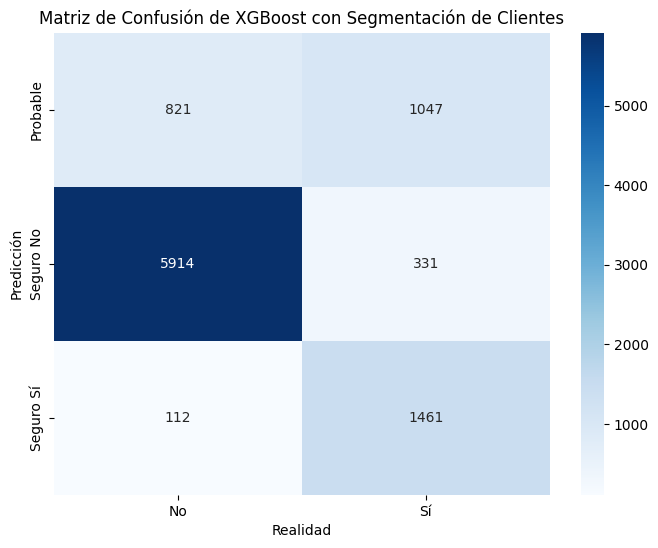

Realidad      No    Sí
Predicción            
Probable     821  1047
Seguro No   5914   331
Seguro Sí    112  1461


In [77]:
# Definir los umbrales personalizados
umbral_seguro_si = 0.9
umbral_probable_si = 0.65
umbral_probable = 0.25

# Seleccionar el mejor modelo XGBoost basado en recall
best_xgb_params = results_df[results_df['model'] == 'XGBoost'].iloc[0].drop(
    ['accuracy', 'f1_score', 'recall', 'roc_auc', 'cv_recall']
).to_dict()

# Crear el modelo con los mejores hiperparámetros
best_xgb = xgb.XGBClassifier(
    n_estimators=int(best_xgb_params['n_estimators']),
    learning_rate=best_xgb_params['learning_rate'],
    max_depth=int(best_xgb_params['max_depth']),
    min_samples_split=int(best_xgb_params['min_samples_split']),
    min_samples_leaf=int(best_xgb_params['min_samples_leaf']),
    random_state=42
)

# Entrenar el modelo
best_xgb.fit(X_train, y_train)

# Obtener las probabilidades de compra
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Función para clasificar clientes según los umbrales
def categorize_customers(prob):
    if prob >= umbral_seguro_si:
        return "Seguro Sí"
    
    elif prob >= umbral_probable:
        return "Probable"
    else:
        return "Seguro No"

# Aplicar la clasificación a cada probabilidad
y_pred_categories_xgb = np.array([categorize_customers(p) for p in y_pred_proba_xgb])

# Crear DataFrame con predicciones y realidad
results_df_xgb = pd.DataFrame({
    "Predicción": y_pred_categories_xgb,
    "Realidad": y_test.map({1: "Sí", 0: "No"})  # Convertir valores 1/0 en Sí/No
})

# Crear matriz de confusión para visualizar la segmentación
conf_matrix_xgb = pd.crosstab(results_df_xgb["Predicción"], results_df_xgb["Realidad"], rownames=["Predicción"], colnames=["Realidad"])

# Graficar la Matriz de Confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap="Blues")
plt.title("Matriz de Confusión de XGBoost con Segmentación de Clientes")
plt.show()

# Mostrar la tabla con los datos de la matriz de confusión
print(conf_matrix_xgb)


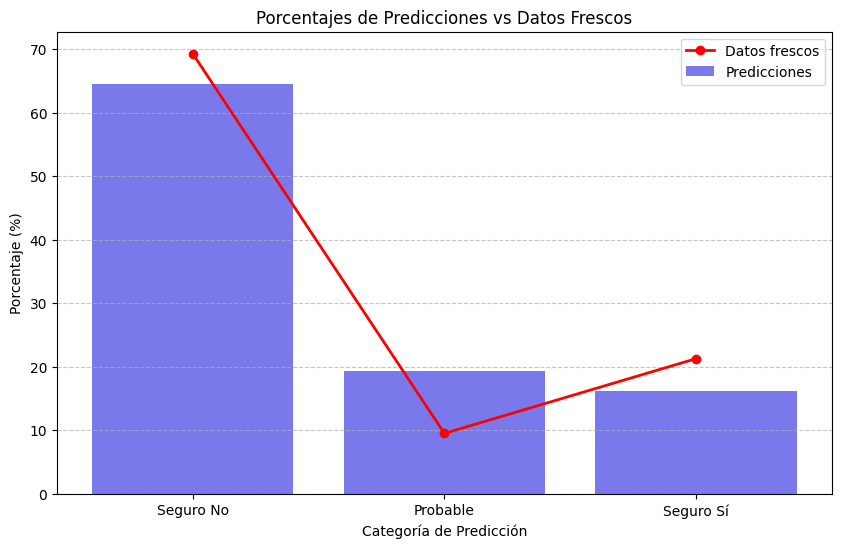

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define el orden específico de las categorías
category_order = ['Seguro No', 'Probable', 'Seguro Sí']

# Contar las frecuencias de cada categoría en los datos predecidos (en porcentaje)
pred_counts = results_df_xgb["Predicción"].value_counts(normalize=True).reindex(category_order, fill_value=0) * 100

# Obtener las probabilidades de compra en el dataset nuevo
y_proba_frescos = best_xgb.predict_proba(X)[:, 1]

# Clasificar los nuevos datos según los umbrales
y_pred_frescos = np.array([categorize_customers(p) for p in y_proba_frescos])

# Contar las frecuencias de cada categoría en los datos frescos (en porcentaje)
fresh_counts = pd.Series(y_pred_frescos).value_counts(normalize=True).reindex(category_order, fill_value=0) * 100

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar las predicciones (barra azul)
sns.barplot(x=pred_counts.index, y=pred_counts.values, color='blue', alpha=0.6, label="Predicciones")

# Graficar los datos frescos (línea roja)
plt.plot(fresh_counts.index, fresh_counts.values, marker='o', color='red', linestyle='-', linewidth=2, label="Datos frescos")

# Configurar etiquetas y título
plt.xlabel("Categoría de Predicción")
plt.ylabel("Porcentaje (%)")
plt.title("Porcentajes de Predicciones vs Datos Frescos")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


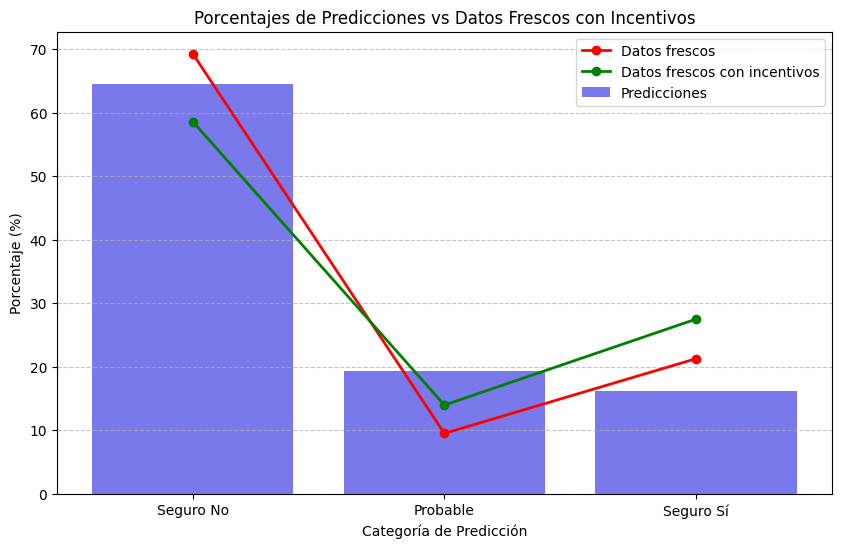

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Definir los umbrales personalizados
umbral_seguro_si = 0.9

umbral_probable = 0.4

# Define el orden específico de las categorías
category_order = ['Seguro No', 'Probable', 'Seguro Sí']

# Aplicar incentivos según los umbrales
def aplicar_incentivo(probabilidad):
    if probabilidad >= umbral_seguro_si:
        # Para los que ya están en "Seguro Sí", aumentamos un poco la probabilidad
        return probabilidad + 0.02  # Incremento pequeño
 
    elif probabilidad >= umbral_probable:
        # Para "Probable No", aumentamos más la probabilidad
        return probabilidad + 0.2  # Incremento grande
    else:
        # Para los que están en "Seguro No", les damos un pequeño incentivo para llamar su atención
        return probabilidad + 0.35  # EL mayor incentivo

# Obtener las probabilidades de compra en el dataset nuevo
y_proba_frescos = best_xgb.predict_proba(X)[:, 1]

# Aplicar los incentivos
y_proba_frescos_incentivados = np.array([aplicar_incentivo(p) for p in y_proba_frescos])

# Clasificar los nuevos datos según los umbrales
y_pred_frescos_incentivados = np.array([categorize_customers(p) for p in y_proba_frescos_incentivados])

# Contar las frecuencias de cada categoría en los datos predecidos (en porcentaje)
pred_counts = results_df_xgb["Predicción"].value_counts(normalize=True).reindex(category_order, fill_value=0) * 100

# Contar las frecuencias de cada categoría en los datos frescos (en porcentaje)
fresh_counts = pd.Series(y_pred_frescos).value_counts(normalize=True).reindex(category_order, fill_value=0) * 100

# Contar las frecuencias de cada categoría en los datos frescos con incentivos (en porcentaje)
fresh_counts_incentivados = pd.Series(y_pred_frescos_incentivados).value_counts(normalize=True).reindex(category_order, fill_value=0) * 100

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar las predicciones (barra azul)
sns.barplot(x=pred_counts.index, y=pred_counts.values, color='blue', alpha=0.6, label="Predicciones")

# Graficar los datos frescos (línea roja)
plt.plot(fresh_counts.index, fresh_counts.values, marker='o', color='red', linestyle='-', linewidth=2, label="Datos frescos")

# Graficar los datos frescos con incentivos (línea verde)
plt.plot(fresh_counts_incentivados.index, fresh_counts_incentivados.values, marker='o', color='green', linestyle='-', linewidth=2, label="Datos frescos con incentivos")

# Configurar etiquetas y título
plt.xlabel("Categoría de Predicción")
plt.ylabel("Porcentaje (%)")
plt.title("Porcentajes de Predicciones vs Datos Frescos con Incentivos")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()
